In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load Dataset
df = pd.read_csv('../Training Dataset/final_dataset.csv', encoding='utf-8-sig')
df = df[df.columns[-2:]]  # Only get sentence and labels

In [3]:
# Get Sentences data from data frame
sentences = df['Sentence'].values
labels = df['Label'].values

In [4]:
# Ensure sentences are strings and handle NaN or non-string values
sentences = df['Sentence'].fillna('').astype(str).values

# Convert to ASCII
def convert_to_ascii(sentence):
    sentence_ascii = []
    for char in sentence:
        if ord(char) < 8222:
            if ord(char) == 8217:  # ’
                sentence_ascii.append(134)
            elif ord(char) == 8221:  # ”
                sentence_ascii.append(129)
            elif ord(char) == 8220:  # “
                sentence_ascii.append(130)
            elif ord(char) == 8216:  # ‘
                sentence_ascii.append(131)
            elif ord(char) == 8211:  # –
                sentence_ascii.append(133)
            if ord(char) <= 128:
                sentence_ascii.append(ord(char))
    zer = np.zeros((10000,))
    for i in range(len(sentence_ascii)):
        zer[i] = sentence_ascii[i]
    zer.shape = (100, 100)
    return zer

In [5]:
# Prepare Data
arr = np.zeros((len(sentences), 100, 100))
for i in range(len(sentences)):
    image = convert_to_ascii(sentences[i])
    x = np.asarray(image, dtype='float')
    image = cv2.resize(x, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    image /= 128
    arr[i] = image

# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 1, 100, 100)

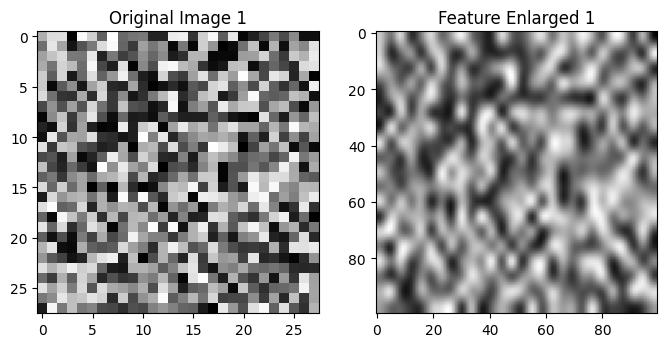

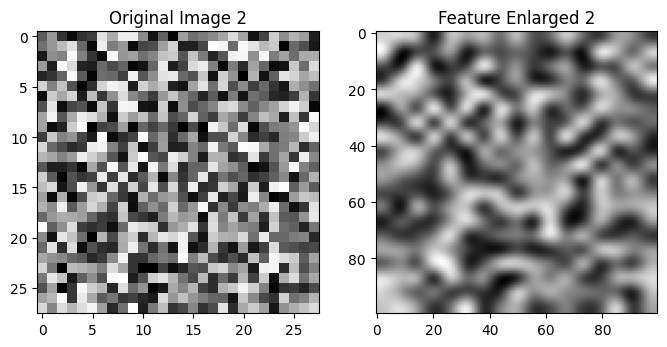

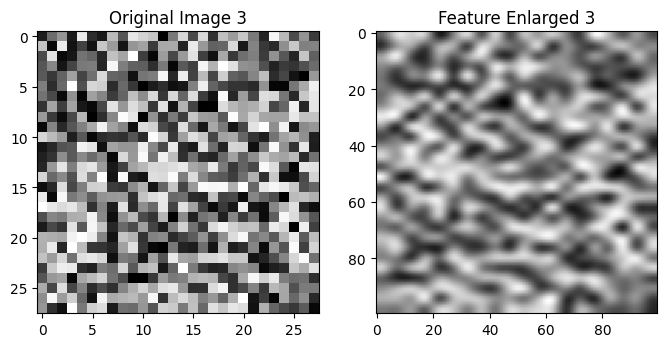

In [6]:
arr = np.random.rand(10, 28, 28)  # shape: (10, 28, 28)

# 顯示進入 CNN 前的前三張圖片
for i in range(3):
    # 原始處理後的圖片
    image = arr[i]
    
    # 使用邊緣檢測尋找特徵區域
    edges = cv2.Canny((image * 255).astype(np.uint8), threshold1=30, threshold2=100)
    
    # 找到最大的特徵區域 (輪廓)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # 根據面積排序找到最大的輪廓
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        x, y, w, h = cv2.boundingRect(contours[0])  # 獲取特徵區域的邊界框
        
        # 裁剪並放大該特徵區域
        cropped = image[y:y+h, x:x+w]
        enlarged = cv2.resize(cropped, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
        
        # 顯示原始圖片與特徵部分
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original Image {i+1}')
        plt.subplot(1, 2, 2)
        plt.imshow(enlarged, cmap='gray')
        plt.title(f'Feature Enlarged {i+1}')
        plt.show()
    else:
        print(f"No significant features detected in Image {i+1}")


In [7]:
# Create PyTorch Dataset
class XSSDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Split data: train 70%, verify 20%, test 10%
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, random_state=42)
verify_data, test_data, verify_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1/3, random_state=42)

train_dataset = XSSDataset(train_data, train_labels)
verify_dataset = XSSDataset(verify_data, verify_labels)
test_dataset = XSSDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
verify_loader = DataLoader(verify_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

: 

In [8]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Train and test with different learning rates
learning_rates = [0.001, 0.002, 0.01, 0.02, 0.05]
num_epochs = 50
all_loss_train = []
all_loss_verify = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = CNNModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_train = []
    loss_verify = []

    best_val_loss = float('inf')  # 儲存最低的驗證損失
    best_model_state = None  # 儲存對應的最佳模型權重

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_train.append(epoch_loss / len(train_loader))

        # Validation loss
        model.eval()
        verify_loss = 0
        with torch.no_grad():
            for inputs, labels in verify_loader:
                outputs = model(inputs.float())
                loss = criterion(outputs.squeeze(), labels.float())
                verify_loss += loss.item()
        loss_verify.append(verify_loss / len(verify_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_train[-1]:.4f}, Verify Loss: {loss_verify[-1]:.4f}")

        # 儲存最佳模型權重
        if verify_loss < best_val_loss:
            best_val_loss = verify_loss
            best_model_state = model.state_dict()

    # 儲存訓練和驗證損失
    all_loss_train.append(loss_train)
    all_loss_verify.append(loss_verify)

    # 保存最佳模型
    model_filename = f"MLP_model_lr_{lr}.pth"
    torch.save(best_model_state, model_filename)
    print(f"Model saved as {model_filename}")

    # 繪製損失曲線並保存
    plt.figure()
    plt.plot(range(1, num_epochs + 1), loss_train, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), loss_verify, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves (Learning Rate: {lr})')
    plt.savefig(f'CNN_loss_plot_lr_{lr}.png')
    print(f"Loss plot saved as CNN_loss_plot_lr_{lr}.png")
    plt.close()


Training with learning rate: 0.001
Epoch [1/50], Training Loss: 0.3534, Verify Loss: 0.2144
Epoch [2/50], Training Loss: 0.1416, Verify Loss: 0.0943
Epoch [3/50], Training Loss: 0.0889, Verify Loss: 0.0665
Epoch [4/50], Training Loss: 0.0675, Verify Loss: 0.0532
Epoch [5/50], Training Loss: 0.0548, Verify Loss: 0.0625
Epoch [6/50], Training Loss: 0.0488, Verify Loss: 0.0463
Epoch [7/50], Training Loss: 0.0411, Verify Loss: 0.0546
Epoch [8/50], Training Loss: 0.0380, Verify Loss: 0.0429
Epoch [9/50], Training Loss: 0.0342, Verify Loss: 0.0402
Epoch [10/50], Training Loss: 0.0308, Verify Loss: 0.0411
Epoch [11/50], Training Loss: 0.0286, Verify Loss: 0.0730
Epoch [12/50], Training Loss: 0.0287, Verify Loss: 0.0518
Epoch [13/50], Training Loss: 0.0250, Verify Loss: 0.0431
Epoch [14/50], Training Loss: 0.0254, Verify Loss: 0.0549
